In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import curdoc, output_notebook, push_notebook, reset_output
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Blues4
from bokeh.plotting import figure, show
from ipywidgets import interact

Load Data to Dataframe

In [2]:
df = pd.read_csv("../data/combined.csv")

Here are the column names and their meanings are from hockey reference website. Explanations are in the cols.txt file. 

In [3]:
df.columns

Index(['Player', 'Age', 'Tm', 'Pos_x', 'GP_x', 'G', 'A', 'PTS', '+/-', 'PIM',
       'PS', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%', 'TOI',
       'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%', 'Pos_y', 'GP_y', 'CF', 'CA',
       'CF%', 'CF% rel', 'FF', 'FA', 'FF%', 'FF% rel', 'oiSH%', 'oiSV%', 'PDO',
       'oZS%', 'dZS%', 'TOI/60', 'TOI(EV)', 'TK', 'GV', 'E+/-', 'SAtt.',
       'Thru%'],
      dtype='object')

We have multiple columns for Positions and Games Played. Lets just get rid of those immediately.

In [4]:
df = df.drop(['Pos_y', 'GP_y'], axis = 1)
df = df.rename(columns={"Pos_x": "Pos", "GP_x": "GP"})

In [5]:
df.head()

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,PDO,oZS%,dZS%,TOI/60,TOI(EV),TK,GV,E+/-,SAtt.,Thru%
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,...,98.2,46.3,53.7,10:13,9:11,0,3,0.2,12,66.7
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,...,99.1,52.0,48.0,11:59,10:38,8,6,2.7,52,61.5
2,Calen Addison,21,MIN,D,15,2,2,4,-4,2,...,94.4,50.5,49.5,13:47,12:16,0,1,3.0,36,47.2
3,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,...,100.0,50.0,50.0,6:52,6:52,0,0,-0.2,1,100.0
4,Jack Ahcan,24,BOS,D,6,1,0,1,-3,0,...,92.1,59.2,40.8,16:02,15:29,1,4,1.2,14,35.7


Lets take a look at the column data types.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 47 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   1003 non-null   object 
 1   Age      1003 non-null   int64  
 2   Tm       1003 non-null   object 
 3   Pos      1003 non-null   object 
 4   GP       1003 non-null   int64  
 5   G        1003 non-null   int64  
 6   A        1003 non-null   int64  
 7   PTS      1003 non-null   int64  
 8   +/-      1003 non-null   int64  
 9   PIM      1003 non-null   int64  
 10  PS       1003 non-null   float64
 11  EV       1003 non-null   int64  
 12  PP       1003 non-null   int64  
 13  SH       1003 non-null   int64  
 14  GW       1003 non-null   int64  
 15  EV.1     1003 non-null   int64  
 16  PP.1     1003 non-null   int64  
 17  SH.1     1003 non-null   int64  
 18  S        1003 non-null   int64  
 19  S%       975 non-null    float64
 20  TOI      1003 non-null   int64  
 21  ATOI     1003 

Lets see what variables are most related to one another (ie. Pearsons Correlation Coefficient)

<AxesSubplot:>

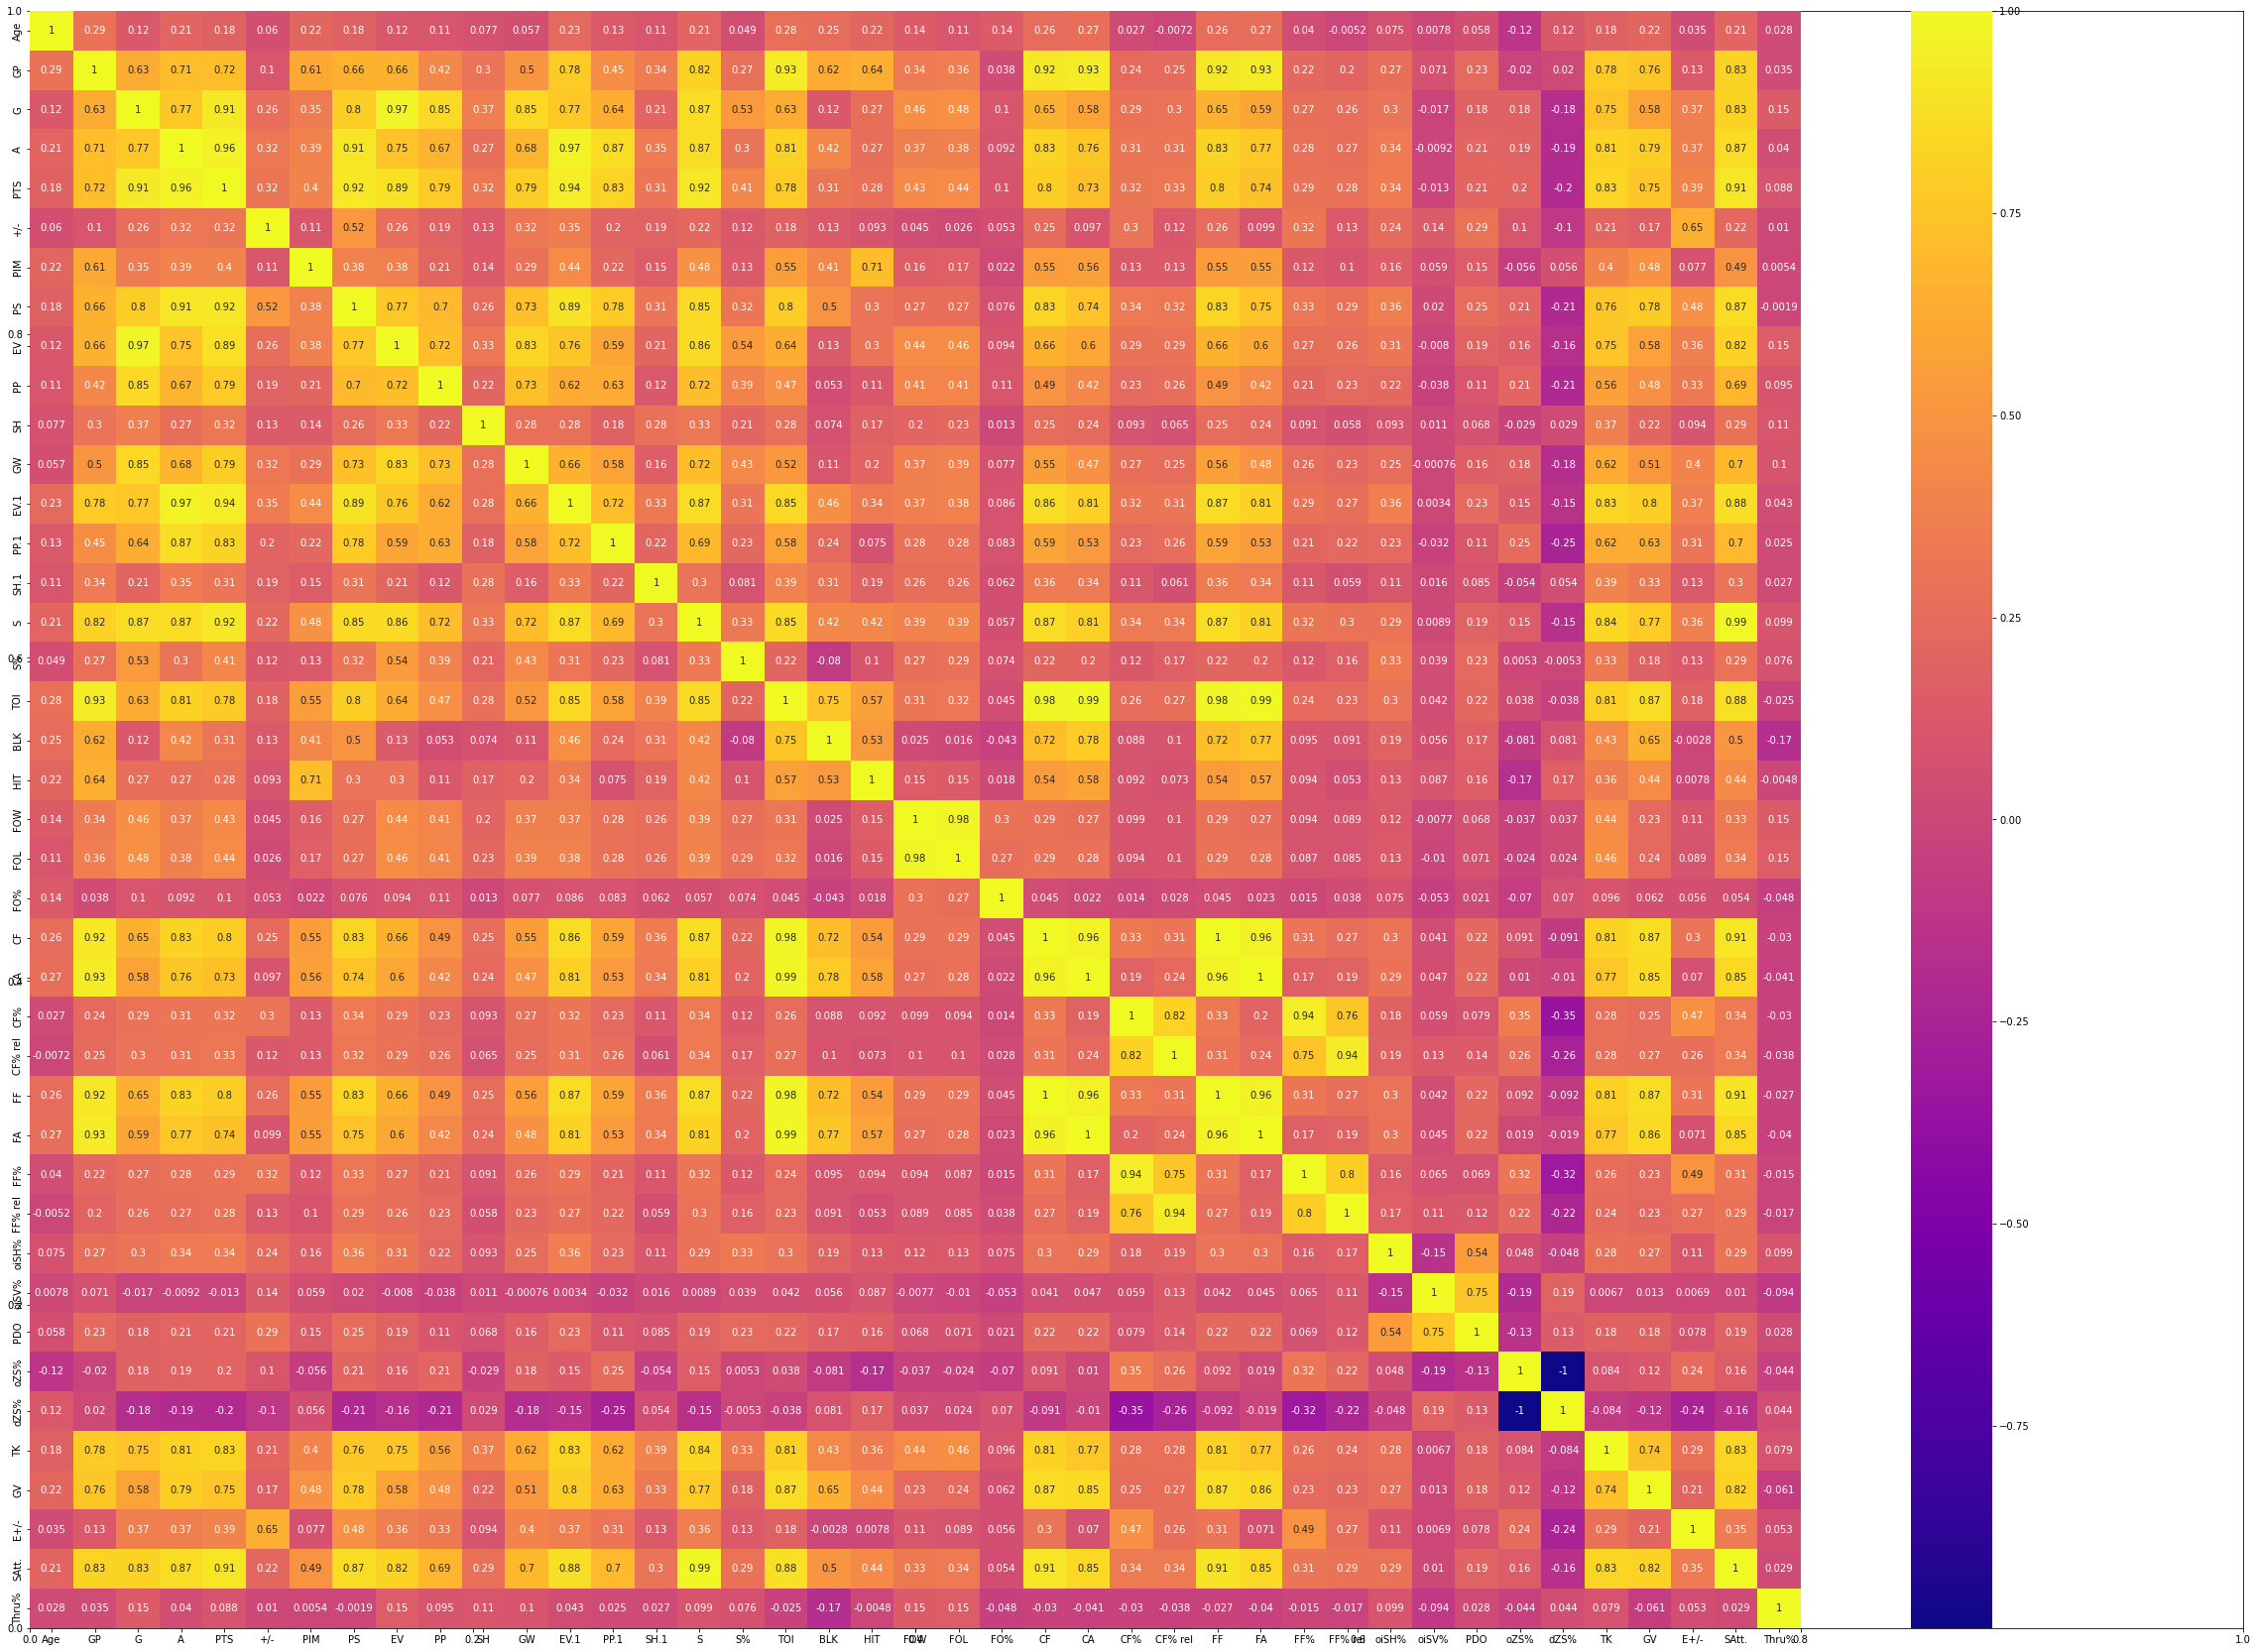

In [7]:
plt.subplots(figsize=(40, 30))
ax = plt.axes()
corr = df.corr()

sns.heatmap(corr,
            annot=True,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
          cmap = plt.cm.plasma)

Wow that's a lot. How about we just focus on correlations as they pertain to Goals?

<AxesSubplot:>

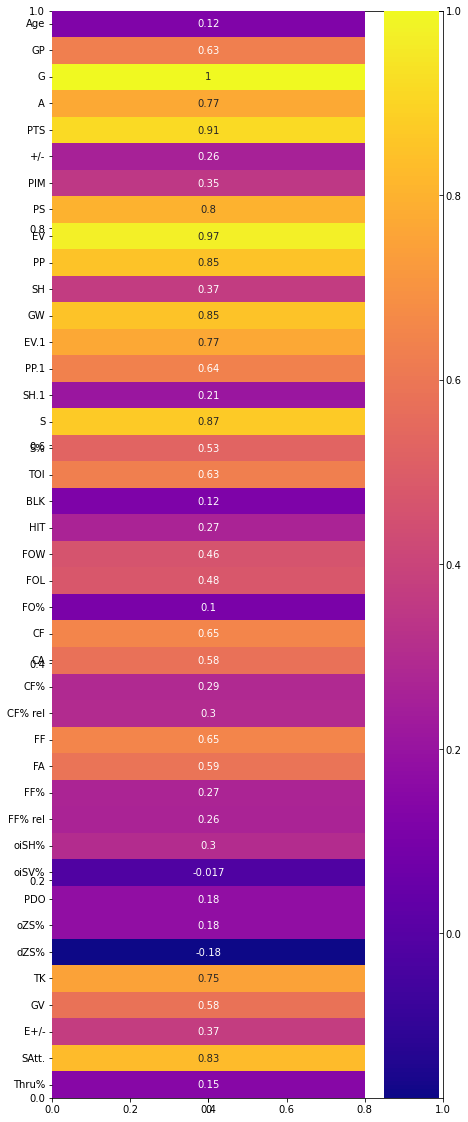

In [8]:
plt.subplots(figsize=(7, 20))
ax = plt.axes()
corr = df.corrwith(df['G'])
corr = pd.DataFrame(corr)
corr = corr.rename(columns={"0": "G"})


sns.heatmap(corr,
            annot=True,
            cmap = plt.cm.plasma)

Here we see some of the correlation coefficients with the goals scored. We see that most of the highly correlated variables are generally what you would expect like shots, points, and shot attempts. Interesting variables that may have some substance for a future model are takeaways, corsi, and fenwick scores. The corsi and fenwick raw scores aren't surprising since these are based on shots + misses (and blocks for corsi), though it is interesting that the % and rel % for these scores have lower coefficients. Takeaways is a fun variable that has a high coefficient, which makes sense since players that are able to recover the puck (thus posses the puck more) would score more.  

In [9]:
df["GPG"] = df["G"]/df["GP"]

In [10]:
player_goals_per_game = df[["Player", "GP", "GPG"]]
top_20_gpg = player_goals_per_game.sort_values(by=["GPG"], ascending=False).head(20)
all_gpg = player_goals_per_game.sort_values(by=["GPG"], ascending=False)

<AxesSubplot:>

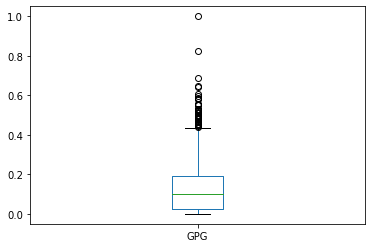

In [11]:
all_gpg.boxplot(column=['GPG'], grid=False)

array([[<AxesSubplot:title={'center':'GPG'}>]], dtype=object)

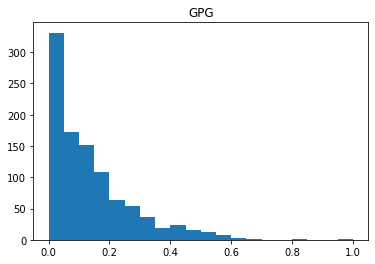

In [12]:
all_gpg.hist(column=["GPG"], grid=False, bins=20)

In [13]:
all_gpg.describe()

,GP,GPG
count,1003.000000,1003.000000
mean,47.030907,0.133683
std,29.243797,0.138981
min,1.000000,0.000000
25%,15.500000,0.025808
50%,57.000000,0.098361
75%,74.000000,0.191899
max,82.000000,1.000000


In [14]:
all_gpg["GPG"].median()

0.09836065573770492

We see that the distribution of data for goals per game is right skewed where the median < mean which shows that there are significantly more players who don't generate as much goals per game as the average for the data set. The mean being .13 game and median being .098. 

Our boxplot shows that there are a good quantity of outliers to the dataset, likely NHL stars and/or players who scored but played very few games. 

We are interested in goals though, lets see if we can compare some of our variables to goals then. 

In [82]:
output_notebook()

Loading BokehJS ...

In [102]:
def create_figure(ind_var):
    source = ColumnDataSource(df)

    tool_tips = [
        ('Player', "@Player")
    ]

    p = figure(height=600, width=800, tools='pan,box_zoom,hover,reset,lasso_select', tooltips=tool_tips)

    p.circle(ind_var, "G", source=source)
    
    p.xaxis.axis_label = ind_var
    p.yaxis.axis_label = "Goals"
    p.title.text = f"Goals vs. {ind_var}"
    
    show(p)
    
    return p

In [101]:
interact(create_figure, ind_var=sorted(df.columns))

interactive(children=(Dropdown(description='ind_var', options=('+/-', 'A', 'ATOI', 'Age', 'BLK', 'CA', 'CF', '…

<function __main__.create_figure(ind_var)>